# Intro Task, Object Localization 

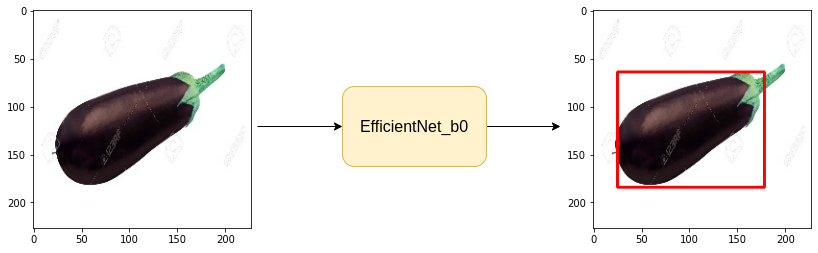

In [1]:
# install libraries/packages/modules 

!pip install -U --q git+https://github.com/albumentations-team/albumentations
!pip install --q timm
!pip install --upgrade --q opencv-contrib-python

     |████████████████████████████████| 509 kB 11.7 MB/s 


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 5.93 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [8]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 1e-3
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df.shape

(186, 8)

In [7]:
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

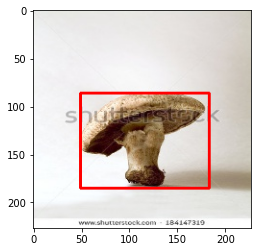

In [14]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bnd_box_img = cv2.rectangle(img, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [15]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [16]:
import albumentations as A

In [19]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [20]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df.reset_index(drop=True)
        self.augmentations = augmentations

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        xmin = row.xmin
        xmax = row.xmax
        ymin = row.ymin
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations is not None:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox

In [23]:
trainset = ObjLocDataset(train_df, augmentations=train_augs)
validset = ObjLocDataset(valid_df, augmentations=valid_augs)

In [24]:
print(f'Total examples in the trainset: {len(trainset)}')
print(f'Total examples in the validset: {len(validset)}')

Total examples in the trainset: 148
Total examples in the validset: 38


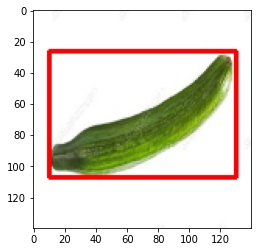

In [25]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [28]:
images, bboxes = next(iter(trainloader))


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [29]:
from torch import nn 
import timm

In [41]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()

        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

    def forward(self, images, gt_bboxes=None):
        bboxes = self.backbone(images)

        if gt_bboxes is not None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

In [42]:
model = ObjLocModel()
model.to(DEVICE);

# Create Train and Eval Function

In [43]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()

    for data in tqdm(dataloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [47]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)

            total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [49]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    optimizer.zero_grad()
    
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f'Epoch: {i+1}; train loss: {train_loss}; valid loss: {valid_loss};')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1; train loss: 1880.6742553710938; valid loss: 764.1251424153646;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2; train loss: 937.2070190429688; valid loss: 537.0780537923177;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3; train loss: 624.1490905761718; valid loss: 238.39311726888022;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4; train loss: 415.5885894775391; valid loss: 137.13152567545572;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5; train loss: 301.5384292602539; valid loss: 115.65204366048177;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6; train loss: 254.2923110961914; valid loss: 142.1207504272461;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7; train loss: 201.75077209472656; valid loss: 135.8965861002604;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8; train loss: 137.44322204589844; valid loss: 113.34508260091145;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9; train loss: 116.83700866699219; valid loss: 123.11620076497395;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10; train loss: 106.99390563964843; valid loss: 95.45806121826172;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11; train loss: 101.49533233642578; valid loss: 90.45283889770508;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12; train loss: 86.36843910217286; valid loss: 90.19470087687175;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13; train loss: 83.37170104980468; valid loss: 120.58640034993489;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14; train loss: 71.58654174804687; valid loss: 113.423158009847;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15; train loss: 75.32338829040528; valid loss: 63.06620407104492;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16; train loss: 72.12980461120605; valid loss: 73.83649444580078;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17; train loss: 62.99131546020508; valid loss: 65.83761723836263;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18; train loss: 55.013468170166014; valid loss: 59.6100222269694;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19; train loss: 57.6160852432251; valid loss: 57.05327479044596;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20; train loss: 54.587238502502444; valid loss: 50.49456532796224;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21; train loss: 59.83482360839844; valid loss: 55.30464553833008;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22; train loss: 45.51806831359863; valid loss: 46.591871897379555;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23; train loss: 43.85080223083496; valid loss: 81.633970896403;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24; train loss: 49.413268089294434; valid loss: 61.37562561035156;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25; train loss: 47.090504837036136; valid loss: 67.97746340433757;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26; train loss: 62.473830986022946; valid loss: 91.50341542561848;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27; train loss: 53.59406147003174; valid loss: 62.26568094889323;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28; train loss: 38.28031463623047; valid loss: 56.40347035725912;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29; train loss: 44.61895542144775; valid loss: 61.86488342285156;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30; train loss: 49.89744129180908; valid loss: 83.15569178263347;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31; train loss: 45.26216487884521; valid loss: 47.14907201131185;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32; train loss: 48.411184310913086; valid loss: 43.48993047078451;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33; train loss: 39.69028587341309; valid loss: 53.89608510335287;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34; train loss: 40.49395751953125; valid loss: 55.35222880045573;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35; train loss: 46.17978172302246; valid loss: 76.5885861714681;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36; train loss: 43.20491390228271; valid loss: 49.96789805094401;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37; train loss: 37.00245914459229; valid loss: 46.87743631998698;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38; train loss: 41.77253646850586; valid loss: 59.77708053588867;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39; train loss: 43.619887351989746; valid loss: 72.4211196899414;


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40; train loss: 43.306295204162595; valid loss: 75.44107182820638;


#Inference

In [51]:
import utils

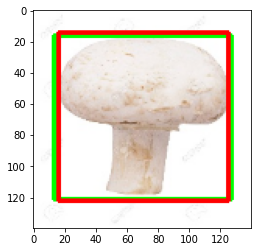

In [52]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[1]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya